# Merchant Fraud Detection Model

v add consumer_fraud_prob_avg, match it with consumer id disini n maybe transaction count nya?, pkoke ambil cmn consumer_fraud_prob_avg!!
v pake df_base itu smua yg 13 jt rows, u can still see msih ada NULL, itu krn cust_fraud nya masi NULL bnyk soalnya blm dijoinn sama notebook6 krn notebook 4 msih errors
-->
but after joining, we still have 300,000 rows of null consumer_prob_fraud_avg
v all given x merchant fraud
v include merchant fraud buat each transaction (dataset namanya merchant fraud)
v predict yg tx_fraud_merchant
v yg dimau itu total (dollar value x transaction fraud prob) --> merchant fraud prob

v 60% ada value 40% null, train data dri 60% bagi jd 2 40 utk train 20 utk tes. klo tes nya bgs, apply model to that 40% null

why xgboost, gdb? bcs it is good on weakly correlated features.
why rf? bcs we dont know what to eliminate so we use rf so it can eliminate unnecessary features by itself

## Import Libraries

In [1]:
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import shutil
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.regression import GBTRegressor
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from itertools import product
import glob

## Start Pyspark

In [3]:
spark = (
    SparkSession.builder.appName("Merchant Fraud Detection")
    .config("spark.driver.memory", "12g")          
    .config("spark.executor.memory", "12g")      
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.files.maxPartitionBytes", "64m")
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow")
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") 
    .getOrCreate()
)
spark.conf.set("spark.sql.parquet.outputTimestampType", "TIMESTAMP_MICROS")

25/09/30 17:59:47 WARN Utils: Your hostname, MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
25/09/30 17:59:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/30 17:59:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/30 17:59:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Datasets

Since the transactions dataset is having timestamps ns, we need to convert it to timestamps us

In [ ]:
# Paths
CLE = Path("../data/cleaned")
CUR = Path("../data/curated")

SRC_TX = CUR / "all_given_data.parquet"           # ORIGINAL (timestamps ns)
DST_TX = CUR / "all_given_data_us.parquet"        # CONVERTED (timestamps us)
SRC_MF = CLE / "merchant_fraud.parquet"           # ORIGINAL (timestamps ns)
DST_MF = CLE / "merchant_fraud_us.parquet"        # CONVERTED (timestamps us)
CF_I = CUR / "consumer_fraud_prob_imputed.parquet"        


print("SRC exists? ", SRC_TX.exists(), SRC_TX)
print("DST exists? ", DST_TX.exists(), DST_TX)

SRC exists?  True data/curated/all_given_data.parquet
DST exists?  True data/curated/all_given_data_us.parquet


In [8]:
# All given datasets
def convert_parquet_ns_to_us(src: Path, dst: Path):
    # Remove any old output
    if dst.exists():
        shutil.rmtree(dst) if dst.is_dir() else dst.unlink()
    dataset = ds.dataset(str(src), format="parquet")
    table = dataset.to_table()

    pq.write_table(
        table,
        where=str(dst),
        coerce_timestamps="us",
        allow_truncated_timestamps=True,
        use_deprecated_int96_timestamps=False
    )
    print(f"Rewrote\n  {src}\n→ {dst}")

# All given datasets
convert_parquet_ns_to_us(SRC_TX, DST_TX)
all_given = spark.read.parquet(str(DST_TX))

# Merchant fraud datasets
convert_parquet_ns_to_us(SRC_MF, DST_MF)
merchant_fraud = spark.read.parquet(str(DST_MF))

# Consumer fraud datasets
consumer_fraud = spark.read.parquet(str(CF_I))

Rewrote
  data/curated/all_given_data.parquet
→ data/curated/all_given_data_us.parquet
Rewrote
  data/cleaned/merchant_fraud.parquet
→ data/cleaned/merchant_fraud_us.parquet


In [5]:
# Quick inspection
print("\n=== all_given schema ===")
all_given.printSchema()

print("\n=== merchant_fraud schema ===")
merchant_fraud.printSchema()

print("\n=== consumer_fraud schema ===")
consumer_fraud.printSchema()


=== all_given schema ===
root
 |-- user_id: string (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: timestamp_ntz (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- unique_merchants: long (nullable = true)
 |-- avg_spend: double (nullable = true)
 |-- consumer_fraud_prob_avg: double (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SA2_code: string (nullable = true)
 |-- SA2_name: string (nullable = true)
 |-- is_po_box: boolean (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (cont

## Merge Datasets

In [6]:
# Merge all_given and merchant_fraud
tx_dataset = (
    all_given.join(
        merchant_fraud,
        on=["merchant_abn", "order_datetime"], 
        how="left"
    )
)

tx_imputed_consumer = (
    tx_dataset
      .join(consumer_fraud, on="consumer_id", how="left")   # preserves all tx rows
      .withColumn(
          "consumer_fraud_prob_avg_imputed_flag",
          (F.col("consumer_fraud_prob_avg").isNull() & F.col("consumer_fraud_prob_avg_filled").isNotNull()).cast("int")
      )
      .withColumn(
          "consumer_fraud_prob_avg",
          F.coalesce(F.col("consumer_fraud_prob_avg"), F.col("consumer_fraud_prob_avg_filled"))
      )
      .drop("consumer_fraud_prob_avg_filled")  # clean up helper column
)

## Map "type" to Numbers

In [7]:
# Map type → numeric index
indexer = StringIndexer(inputCol="type", outputCol="type_num", handleInvalid="keep")
df = indexer.fit(tx_imputed_consumer).transform(tx_imputed_consumer)

# Drop old string column if you want, keep type_num as double
df_mapped = df.drop("type").withColumnRenamed("type_num", "type")

In [8]:
df_mapped.show(5, truncate=False)
df_mapped.printSchema()
df_mapped.count()

25/09/27 00:49:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+------------+-------------------+-------+------------------+------------------------------------+-----------------+------------------+----------------+------------------+-----------------------+----------------+----------------------------+-----+--------+------+---------+----------------------+---------+-----------------------------+-----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------+-----------+------------------+------------------+----------------+----------------+-------------------+-----------------+------------------------------------+----+
|consumer_id|merchant_abn|order_datetime     |user_id|dollar_value      |order_id                            |transaction_count|total_spend       |unique_merchants|avg_spend         |consumer_fraud_prob_avg|consumer_name   |address                     |state|postcode|gender|

13614672

In [9]:
null_counts = df_mapped.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_mapped.columns
])

null_counts.show()

+-----------+------------+--------------+-------+------------+--------+-----------------+-----------+----------------+---------+-----------------------+-------------+-------+-----+--------+------+--------+--------+---------+-------------+----+----------+---------+-----------+-----------+---------------+----------------+----------------+---------------+-----------------+------------------------------------+----+
|consumer_id|merchant_abn|order_datetime|user_id|dollar_value|order_id|transaction_count|total_spend|unique_merchants|avg_spend|consumer_fraud_prob_avg|consumer_name|address|state|postcode|gender|SA2_code|SA2_name|is_po_box|merchant_name|tags|categories|take_rate|order_count|total_sales|avg_order_value|unique_consumers|repeat_consumers|repurchase_rate|tx_fraud_merchant|consumer_fraud_prob_avg_imputed_flag|type|
+-----------+------------+--------------+-------+------------+--------+-----------------+-----------+----------------+---------+-----------------------+-------------+----

In [10]:
# Add a stable row id and a flag whether label was missing originally
df_base = (
    df_mapped
      .withColumn("row_id", F.monotonically_increasing_id())
      .withColumn("was_unlabeled", F.col("tx_fraud_merchant").isNull().cast("int"))
)

# Keep a copy of the full, wide schema to join back later
wide_cols = df_base.columns  # includes everything + row_id + was_unlabeled

In [11]:
# just in case, but it should be no na
df_no_na = df_base.na.drop(subset=["consumer_fraud_prob_avg"])

## Modelling

### Split rows

In [12]:
# Keep only rows with tx_fraud_merchant not null
df_labeled = df_no_na.na.drop(subset=["tx_fraud_merchant"])
df_unlabeled = df_no_na.filter(F.col("tx_fraud_merchant").isNull())

print("With label :", df_labeled.count())
print("Without label:", df_unlabeled.count())

With label : 3890


Without label: 13257321


### Select features and label

In [13]:
feature_cols = [
    "dollar_value", "transaction_count", "total_spend", "unique_merchants",
    "avg_spend", "consumer_fraud_prob_avg", "take_rate", "order_count",
    "total_sales", "avg_order_value", "unique_consumers", "repeat_consumers",
    "repurchase_rate", "type"
]

df_labeled = df_labeled.select(*feature_cols, "tx_fraud_merchant", "row_id")

### Train test split

In [14]:
train_df, validation_df = df_labeled.randomSplit([0.8, 0.2], seed=42)

### Assemble features

In [15]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

train_vec = assembler.transform(train_df).select("features", "tx_fraud_merchant")
test_vec  = assembler.transform(validation_df).select("features", "tx_fraud_merchant")

### Evaluator for RMSE and R^2

In [16]:
rmse_eval = RegressionEvaluator(
    labelCol="tx_fraud_merchant",
    predictionCol="prediction",
    metricName="rmse"
)

r2_eval = RegressionEvaluator(
    labelCol="tx_fraud_merchant",
    predictionCol="prediction",
    metricName="r2"
)

## Random Forest Modelling

### Train RandomForestRegressor

In [17]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="tx_fraud_merchant",
    numTrees=100,
    maxDepth=10,
    seed=42
)

### Hyperparameter Tuning

In [18]:
rf_param_grid = (
    ParamGridBuilder()
      .addGrid(rf.numTrees, [100, 300])
      .addGrid(rf.maxDepth, [8, 12])
      .addGrid(rf.maxBins, [64, 128])
      .addGrid(rf.subsamplingRate, [0.7, 1.0])
      .addGrid(rf.featureSubsetStrategy, ["sqrt", "log2"])
      .build()
)

rf_tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=rmse_eval,
    trainRatio=0.8,
    parallelism=4
)

rf_tuned = rf_tvs.fit(train_vec)
rf_best = rf_tuned.bestModel

25/09/27 00:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1171.4 KiB
25/09/27 00:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1171.4 KiB
25/09/27 00:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1129.4 KiB
25/09/27 00:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1129.4 KiB
25/09/27 00:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1645.6 KiB
25/09/27 00:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1645.6 KiB
25/09/27 00:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1563.3 KiB
25/09/27 00:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1563.3 KiB
25/09/27 00:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1137.3 KiB
25/09/27 00:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1137.3 KiB
25/09/27 00:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1174.9 KiB
25/09/27 00:50:02 WAR

### Evaluate on test set

In [19]:
rf_best_rmse = rmse_eval.evaluate(rf_best.transform(test_vec))
rf_best_r2 = r2_eval.evaluate(rf_best.transform(test_vec))

print(f"Random Forest Best Parameters:")
print("  numTrees      =", rf_best.getNumTrees)
print("  maxDepth      =", rf_best.getOrDefault("maxDepth"))
print("  maxBins       =", rf_best.getOrDefault("maxBins"))
print("  subsampling   =", rf_best.getOrDefault("subsamplingRate"))
print("  featureSubset =", rf_best.getOrDefault("featureSubsetStrategy"))
print(f"  RMSE: {rf_best_rmse:.4f}")
print(f"  R2: {rf_best_r2:.4f}")

Random Forest Best Parameters:
  numTrees      = 100
  maxDepth      = 8
  maxBins       = 64
  subsampling   = 1.0
  featureSubset = sqrt
  RMSE: 0.0203
  R2: 0.8744


## Gradient Boost Model

### Train GBTRegressor

In [20]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="tx_fraud_merchant",
    maxIter=200,        
    maxDepth=6,        
    stepSize=0.1,   
    subsamplingRate=0.8,  
    maxBins=128,
    seed=42
)

gbt_model = gbt.fit(train_vec)

25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1005.4 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1010.6 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1013.0 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1019.8 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB
25/09/27 00:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1021.3 KiB
25/09/27 00:52:11 WAR

### Hyperparameter Tuning

In [21]:
gbt_param_grid = (
    ParamGridBuilder()
      .addGrid(gbt.maxIter, [100, 200])
      .addGrid(gbt.maxDepth, [4, 6])
      .addGrid(gbt.stepSize, [0.05, 0.1])
      .addGrid(gbt.subsamplingRate, [0.7, 1.0])
      .build()
)

gbt_tvs = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=rmse_eval,
    trainRatio=0.8,
    parallelism=4
)

gbt_tuned = gbt_tvs.fit(train_vec)
gbt_best = gbt_tuned.bestModel

25/09/27 00:53:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/09/27 00:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
25/09/27 00:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1000.5 KiB
25/09/27 00:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
25/09/27 00:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
25/09/27 00:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
25/09/27 00:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
25/09/27 00:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/09/27 00:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
25/09/27 00:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
25/09/27 00:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
25/

### Evaluate on test set

In [22]:
gbt_best_rmse = rmse_eval.evaluate(gbt_best.transform(test_vec))
gbt_best_r2 = r2_eval.evaluate(gbt_best.transform(test_vec))

print("GBT Best Params:")
print("  maxIter   =", gbt_best.getOrDefault("maxIter"))
print("  maxDepth  =", gbt_best.getOrDefault("maxDepth"))
print("  stepSize  =", gbt_best.getOrDefault("stepSize"))
print("  subsample =", gbt_best.getOrDefault("subsamplingRate"))
print(f"  RMSE: {gbt_best_rmse:.4f}")
print(f"  R2: {gbt_best_r2:.4f}")

GBT Best Params:
  maxIter   = 100
  maxDepth  = 4
  stepSize  = 0.1
  subsample = 1.0
  RMSE: 0.0124
  R2: 0.9531


## XGBoost Model

### Train XGBoost Model and Hyperparemeter Tuning

In [23]:
train_vec_xgb = assembler.transform(train_df).select("features", "tx_fraud_merchant") \
    .withColumn("is_val", F.lit(False).cast("boolean"))
valid_vec_xgb = assembler.transform(validation_df).select("features", "tx_fraud_merchant") \
    .withColumn("is_val", F.lit(True).cast("boolean"))

xgb_input = train_vec_xgb.unionByName(valid_vec_xgb)
xgb_val_only = valid_vec_xgb.select("features", "tx_fraud_merchant")

param_space = {
    "max_depth": [4, 6],
    "eta": [0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [0.0, 1.0],
}

best_xgb = {"rmse": float("inf"), "r2": None, "params": None, "model": None}

rmse_evaluator = RegressionEvaluator(
    labelCol="tx_fraud_merchant", predictionCol="prediction", metricName="rmse"
)
r2_evaluator = RegressionEvaluator(
    labelCol="tx_fraud_merchant", predictionCol="prediction", metricName="r2"
)
for combo in product(*param_space.values()):
    params = dict(zip(param_space.keys(), combo))

    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="tx_fraud_merchant",
        validation_indicator_col="is_val",
        objective="reg:squarederror",
        eval_metric="rmse",
        num_round=500,
        early_stopping_rounds=50,
        tree_method="hist",
        num_workers=4,
        seed=42,
        **params
    )

    xgb_model = xgb.fit(xgb_input)

    preds = xgb_model.transform(xgb_val_only)
    rmse = rmse_evaluator.evaluate(preds)
    r2_eval = r2_evaluator.evaluate(preds)

    print(f"XGB {params} => RMSE={rmse:.4f}, R2={r2_eval:.4f}")

    if rmse < best_xgb["rmse"]:
        best_xgb.update({"rmse": rmse, "r2": r2_eval, "params": params, "model": xgb_model})

2025-09-27 00:58:27,106 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'rmse', 'max_depth': 4, 'reg_lambda': 0.0, 'subsample': 0.7, 'tree_method': 'hist', 'num_round': 500, 'seed': 42, 'eta': 0.05, 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 50, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-09-27 00:58:32,938 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[00:58:33] Task 2 got rank 2[00:58:33] Task 1 got rank 1
[00:58:33] Task 0 got rank 0

[00:58:33] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0144, R2=0.9364


2025-09-27 00:58:49,693 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[00:58:50] Task 3 got rank 3[00:58:50] Task 1 got rank 1[00:58:50] Task 0 got rank 0


[00:58:50] Task 2 got rank 2
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0133, R2=0.9458


2025-09-27 00:59:02,880 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[00:59:03] Task 0 got rank 0                                        (0 + 4) / 4]
[00:59:03] Task 1 got rank 1
[00:59:03] Task 3 got rank 3[00:59:03] Task 2 got rank 2

/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0120, R2=0.9560


2025-09-27 00:59:18,389 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[00:59:19] Task 1 got rank 1                                        (0 + 4) / 4]
[00:59:19] Task 0 got rank 0
[00:59:19] Task 2 got rank 2
[00:59:19] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0123, R2=0.9537


2025-09-27 00:59:31,811 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[00:59:32] Task 2 got rank 2                                        (0 + 4) / 4]
[00:59:32] Task 1 got rank 1
[00:59:32] Task 0 got rank 0
[00:59:32] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0124, R2=0.9532


2025-09-27 00:59:46,451 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[00:59:47] Task 1 got rank 1[00:59:47] Task 0 got rank 0            (0 + 4) / 4]

[00:59:47] Task 3 got rank 3
[00:59:47] Task 2 got rank 2
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [00:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0130, R2=0.9485


2025-09-27 00:59:59,974 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:00:00] Task 1 got rank 1                                        (0 + 4) / 4]
[01:00:00] Task 2 got rank 2
[01:00:00] Task 0 got rank 0[01:00:00] Task 3 got rank 3

/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0149, R2=0.9319


2025-09-27 01:00:12,843 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:00:13] Task 2 got rank 2[01:00:13] Task 1 got rank 1            (0 + 4) / 4]

[01:00:13] Task 3 got rank 3
[01:00:13] Task 0 got rank 0
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 4, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0122, R2=0.9546


2025-09-27 01:00:21,049 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'rmse', 'max_depth': 4, 'reg_lambda': 0.0, 'subsample': 0.7, 'tree_method': 'hist', 'num_round': 500, 'seed': 42, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 50, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-09-27 01:00:26,043 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:00:27] Task 0 got rank 0[01:00:27] Task 1 got rank 1            (0 + 4) / 4]

[01:00:27] Task 3 got rank 3
[01:00:27] Task 2 got rank 2
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Pyt

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0171, R2=0.9110


2025-09-27 01:00:38,872 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:00:39] Task 1 got rank 1[01:00:39] Task 2 got rank 2            (0 + 4) / 4]

[01:00:39] Task 0 got rank 0
[01:00:39] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0141, R2=0.9389


2025-09-27 01:00:51,292 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:00:52] Task 2 got rank 2                                        (0 + 4) / 4]
[01:00:52] Task 1 got rank 1
[01:00:52] Task 0 got rank 0
[01:00:52] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0121, R2=0.9553


2025-09-27 01:01:04,215 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:01:05] Task 0 got rank 0                                        (0 + 4) / 4]
[01:01:05] Task 1 got rank 1
[01:01:05] Task 3 got rank 3
[01:01:05] Task 2 got rank 2
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0123, R2=0.9540


2025-09-27 01:01:16,959 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:01:17] Task 0 got rank 0                                        (0 + 4) / 4]
[01:01:17] Task 1 got rank 1[01:01:17] Task 2 got rank 2[01:01:17] Task 3 got rank 3


/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0113, R2=0.9607


2025-09-27 01:01:29,795 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:01:30] Task 2 got rank 2                                        (0 + 4) / 4]
[01:01:30] Task 1 got rank 1
[01:01:30] Task 0 got rank 0
[01:01:30] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0133, R2=0.9458


2025-09-27 01:01:42,226 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:01:43] Task 1 got rank 1[01:01:43] Task 2 got rank 2            (0 + 4) / 4]

[01:01:43] Task 3 got rank 3
[01:01:43] Task 0 got rank 0
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0151, R2=0.9305


2025-09-27 01:01:50,289 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'device': 'cpu', 'eval_metric': 'rmse', 'max_depth': 4, 'reg_lambda': 1.0, 'subsample': 1.0, 'tree_method': 'hist', 'num_round': 500, 'seed': 42, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 50, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-09-27 01:01:54,910 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:01:55] Task 1 got rank 1[01:01:55] Task 3 got rank 3            (0 + 4) / 4]

[01:01:55] Task 0 got rank 0
[01:01:55] Task 2 got rank 2
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:01:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Pyt

XGB {'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0124, R2=0.9530


2025-09-27 01:02:07,138 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:02:08] Task 1 got rank 1                                        (0 + 4) / 4]
[01:02:08] Task 3 got rank 3
[01:02:08] Task 2 got rank 2
[01:02:08] Task 0 got rank 0
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0142, R2=0.9388


2025-09-27 01:02:19,820 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:02:20] Task 0 got rank 0                                        (0 + 4) / 4]
[01:02:20] Task 3 got rank 3
[01:02:20] Task 1 got rank 1
[01:02:20] Task 2 got rank 2
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0137, R2=0.9430


2025-09-27 01:02:34,479 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:02:35] Task 0 got rank 0[01:02:35] Task 2 got rank 2[01:02:35] Task 3 got rank 3[01:02:35] Task 1 got rank 1



/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0131, R2=0.9478


2025-09-27 01:02:47,255 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:02:48] Task 1 got rank 1[01:02:48] Task 2 got rank 2            (0 + 4) / 4]

[01:02:48] Task 0 got rank 0
[01:02:48] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0135, R2=0.9442


2025-09-27 01:03:00,373 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:03:01] Task 2 got rank 2[01:03:01] Task 1 got rank 1            (0 + 4) / 4]

[01:03:01] Task 0 got rank 0
[01:03:01] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0141, R2=0.9396


2025-09-27 01:03:08,291 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'rmse', 'max_depth': 6, 'reg_lambda': 1.0, 'subsample': 1.0, 'tree_method': 'hist', 'num_round': 500, 'seed': 42, 'eta': 0.05, 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 50, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-09-27 01:03:12,980 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:03:13] Task 1 got rank 1                                        (0 + 4) / 4]
[01:03:13] Task 2 got rank 2
[01:03:13] Task 0 got rank 0
[01:03:13] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/User

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0152, R2=0.9291


2025-09-27 01:03:26,671 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:03:27] Task 2 got rank 2                                        (0 + 4) / 4]
[01:03:27] Task 1 got rank 1
[01:03:27] Task 0 got rank 0
[01:03:27] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0180, R2=0.9007


2025-09-27 01:03:35,490 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'device': 'cpu', 'eval_metric': 'rmse', 'max_depth': 6, 'reg_lambda': 1.0, 'subsample': 1.0, 'tree_method': 'hist', 'num_round': 500, 'seed': 42, 'eta': 0.05, 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 50, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-09-27 01:03:40,286 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:03:41] Task 1 got rank 1                                        (0 + 4) / 4]
[01:03:41] Task 2 got rank 2
[01:03:41] Task 0 got rank 0
[01:03:41] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/User

XGB {'max_depth': 6, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0179, R2=0.9026


2025-09-27 01:03:48,643 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 4 workers with
	booster params: {'objective': 'reg:squarederror', 'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'rmse', 'max_depth': 6, 'reg_lambda': 0.0, 'subsample': 0.7, 'tree_method': 'hist', 'num_round': 500, 'seed': 42, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'early_stopping_rounds': 50, 'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-09-27 01:03:53,092 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:03:54] Task 1 got rank 1[01:03:54] Task 2 got rank 2            (0 + 4) / 4]

[01:03:54] Task 0 got rank 0
[01:03:54] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Pyt

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0168, R2=0.9139


2025-09-27 01:04:06,741 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:04:07] Task 2 got rank 2                                        (0 + 4) / 4]
[01:04:07] Task 1 got rank 1[01:04:07] Task 0 got rank 0

[01:04:07] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0141, R2=0.9389


2025-09-27 01:04:19,324 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:04:20] Task 2 got rank 2                                        (0 + 4) / 4]
[01:04:20] Task 0 got rank 0
[01:04:20] Task 1 got rank 1
[01:04:20] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0134, R2=0.9454


2025-09-27 01:04:32,191 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:04:33] Task 1 got rank 1                                        (0 + 4) / 4]
[01:04:33] Task 3 got rank 3
[01:04:33] Task 2 got rank 2
[01:04:33] Task 0 got rank 0
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0128, R2=0.9498


2025-09-27 01:04:45,935 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:04:46] Task 1 got rank 1[01:04:46] Task 2 got rank 2            (0 + 4) / 4]

[01:04:46] Task 0 got rank 0[01:04:46] Task 3 got rank 3

/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 0.0} => RMSE=0.0137, R2=0.9429


2025-09-27 01:04:59,124 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:05:00] Task 1 got rank 1                                        (0 + 4) / 4]
[01:05:00] Task 0 got rank 0[01:05:00] Task 2 got rank 2

[01:05:00] Task 3 got rank 3
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 1.0} => RMSE=0.0160, R2=0.9216


2025-09-27 01:05:11,959 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:05:12] Task 2 got rank 2                                        (0 + 4) / 4]
[01:05:12] Task 1 got rank 1
[01:05:12] Task 3 got rank 3
[01:05:12] Task 0 got rank 0
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg,

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 0.0} => RMSE=0.0178, R2=0.9031


2025-09-27 01:05:23,489 INFO XGBoost-PySpark: _train_booster Training on CPUs34]
[01:05:24] Task 2 got rank 2[01:05:24] Task 1 got rank 1            (0 + 4) / 4]

[01:05:24] Task 3 got rank 3
[01:05:24] Task 0 got rank 0
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicialauretta/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [01:05:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_round" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/felicia

XGB {'max_depth': 6, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0} => RMSE=0.0174, R2=0.9073


### Evaluate on validation set

In [24]:
print("XGB Best Params:", best_xgb["params"])
print(f"  RMSE: {best_xgb['rmse']:.4f}")
print(f"  R2: {best_xgb['r2']:.4f}")
final_xgb_model = best_xgb["model"]

XGB Best Params: {'max_depth': 4, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda': 0.0}
  RMSE: 0.0113
  R2: 0.9607


Since XGBoost Model has the lowest RMSE = 0.0113 and highest R^2 = 0.9607, we decided to move on with XGBoost Model to test the NULL value in the "tx_fraud_merchant"

### Predict on "tx_fraud_merchant "missing values

In [25]:
# Assemble features for unlabeled rows
df_unlabeled_vec = assembler.transform(
    df_unlabeled.select(*feature_cols, "row_id")
)
# Predict
predicted_unlabeled = final_xgb_model.transform(df_unlabeled_vec)

In [26]:
# Get column for predicted "tx_fraud_merchant"
predicted_ready = (
    predicted_unlabeled
      .select(
          "row_id",
          *[F.col(c) for c in feature_cols],
          F.col("prediction").cast("double").alias("tx_fraud_pred") 
      )
)
df_labeled_ready = df_labeled.select(*feature_cols, "tx_fraud_merchant", "row_id")

In [27]:
# Merge all rows after prediction
final_df_model = (
    df_labeled_ready
      .select("row_id", *feature_cols, "tx_fraud_merchant")
      .unionByName(
          predicted_ready
            .select("row_id", *feature_cols, F.col("tx_fraud_pred").alias("tx_fraud_merchant"))
      )
)

### Join back with full features

In [28]:
pred_df = predicted_ready.select("row_id", "tx_fraud_pred")

final_df = (
    df_no_na                                             
      .join(pred_df, on="row_id", how="left")          
      .withColumn(                                 
          "tx_fraud_merchant",
          F.coalesce(F.col("tx_fraud_merchant"), F.col("tx_fraud_pred"))
      )
      .drop("tx_fraud_pred", "was_unlabeled", "row_id")
)

final_df.show(5)

2025-09-27 01:05:32,027 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----------+------------+-------------------+-------+------------------+--------------------+-----------------+------------------+----------------+------------------+-----------------------+----------------+--------------------+-----+--------+-----------+---------+--------------------+---------+--------------------+--------------------+--------------------+---------+-----------+------------------+------------------+----------------+----------------+-------------------+-------------------+------------------------------------+----+
|consumer_id|merchant_abn|     order_datetime|user_id|      dollar_value|            order_id|transaction_count|       total_spend|unique_merchants|         avg_spend|consumer_fraud_prob_avg|   consumer_name|             address|state|postcode|     gender| SA2_code|            SA2_name|is_po_box|       merchant_name|                tags|          categories|take_rate|order_count|       total_sales|   avg_order_value|unique_consumers|repeat_consumers|    repur

In [29]:
final_df.count()

13261211

### Compute each transaction total fraud (dollar value x transaction fraud prob)

In [30]:
final_df = final_df.withColumn(
    "tx_dollar_fraud",
    F.col("dollar_value") * F.col("tx_fraud_merchant")
)

final_df.printSchema()
final_df.show(5, truncate=False)

root
 |-- consumer_id: string (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- order_datetime: timestamp_ntz (nullable = true)
 |-- user_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- unique_merchants: long (nullable = true)
 |-- avg_spend: double (nullable = true)
 |-- consumer_fraud_prob_avg: double (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SA2_code: string (nullable = true)
 |-- SA2_name: string (nullable = true)
 |-- is_po_box: boolean (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- take

2025-09-27 01:06:01,870 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----------+------------+-------------------+-------+------------------+------------------------------------+-----------------+-----------------+----------------+------------------+-----------------------+-----------------+----------------------------+-----+--------+------+---------+-------------------------+---------+-------------------------+-----------------------------------------------------------------------------------------+---------------------------------------------------------------+---------+-----------+------------------+------------------+----------------+----------------+-------------------+------------------+------------------------------------+----+-----------------+
|consumer_id|merchant_abn|order_datetime     |user_id|dollar_value      |order_id                            |transaction_count|total_spend      |unique_merchants|avg_spend         |consumer_fraud_prob_avg|consumer_name    |address                     |state|postcode|gender|SA2_code |SA2_name            

### Return "type" to categorical

In [31]:
letters = ["a", "b", "c", "d", "e"]
final_df = (final_df
  .withColumn("type_abcde", F.element_at(F.array(*[F.lit(x) for x in letters]), F.col("type").cast("int")+1))
  .drop("type")
  .withColumnRenamed("type_abcde", "type")
)

### Rename back to "consumer_fraud_prob_avg_filled"

In [ ]:
final_df = (
    final_df.withColumnRenamed("consumer_fraud_prob_avg_imputed_flag", "consumer_fraud_prob_avg_filled")
)

### Save updated transaction with imputed tx_fraud_merchant

In [32]:
(final_df
    .coalesce(1)
    .write
    .option("header", True)
    .mode("overwrite")
    .parquet("./data/curated/tx_imputed"))

output_dir = "./data/curated/tx_imputed"
part_file = glob.glob(f"{output_dir}/part-*.parquet")[0]
shutil.move(part_file, "./data/curated/tx_imputed.parquet")
shutil.rmtree(output_dir)

2025-09-27 01:06:45,686 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


## Check feature importance

In [33]:
booster = final_xgb_model.get_booster()
score_dict = booster.get_score(importance_type="gain")
assembler_input = feature_cols
rows = []
for fid, val in score_dict.items():
    idx = int(fid[1:])       
    if 0 <= idx < len(assembler_input):
        rows.append((assembler_input[idx], float(val)))

imp_df = pd.DataFrame(rows, columns=["feature", "importance"]).sort_values("importance", ascending=False)
print(imp_df.head(20))

                    feature  importance
8               total_sales    0.209691
11         repeat_consumers    0.088694
7               order_count    0.053099
9           avg_order_value    0.036520
5   consumer_fraud_prob_avg    0.008462
0              dollar_value    0.007839
4                 avg_spend    0.006563
6                 take_rate    0.006357
1         transaction_count    0.006261
2               total_spend    0.005151
12          repurchase_rate    0.004519
10         unique_consumers    0.003916
3          unique_merchants    0.001934


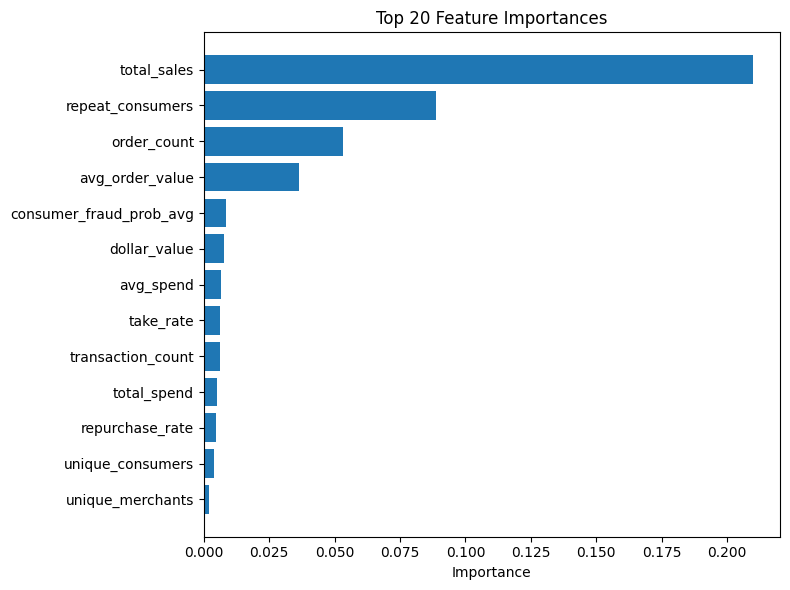

In [34]:
top = imp_df.head(20)
plt.figure(figsize=(8,6))
plt.barh(top["feature"], top["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()

## Merchant Dataset

### Aggregate fraud dollars by merchant

In [35]:
merchant_fraud_sum = (
    final_df.groupBy("merchant_abn")
            .agg(F.sum("tx_dollar_fraud").alias("total_tx_dollar_fraud"))
)
merchant_fraud_sum.show(10, truncate=False)

2025-09-27 01:08:26,752 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+------------+---------------------+
|merchant_abn|total_tx_dollar_fraud|
+------------+---------------------+
|60978195146 |658774.2855801539    |
|11633090957 |32049.038528520116   |
|67165527084 |1033509.7104895692   |
|36866208934 |136355.44890116318   |
|73792600690 |478674.98872998625   |
|33651513345 |564445.0777873097    |
|53074973777 |23066.18882141591    |
|37629693091 |28327.497696707098   |
|87092867947 |26534.778385771264   |
|87284273126 |8262.781347365597    |
+------------+---------------------+
only showing top 10 rows


### Save updated merchant with imputed total_tx_dollar_fraud

In [36]:
(merchant_fraud_sum
    .coalesce(1)
    .write
    .option("header", True)
    .mode("overwrite")
    .parquet("./data/curated/merchant_imputed"))

output_dir = "./data/curated/merchant_imputed"
part_file = glob.glob(f"{output_dir}/part-*.parquet")[0]
shutil.move(part_file, "./data/curated/merchant_imputed.parquet")
shutil.rmtree(output_dir)

2025-09-27 01:08:46,163 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
